# Exploring and building the dataset

In [1]:
import numpy as np
import pandas as pd 
import torch
import torchvision.models  as models
import torch.nn as nn
import torch.optim as optim
from   tqdm import tqdm
from   torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = np.load("adult/adult_train.npz")

In [4]:
header = np.loadtxt("adult/adult_headers.txt", dtype = str )

In [5]:
train_data_X = pd.DataFrame(train_data["x"], columns= header[:-1])
train_data_Y = pd.DataFrame(train_data["y"], columns= [header[-1]])
train_data_A = pd.DataFrame(train_data["a"], columns = ["gender"])

In [6]:
data = pd.concat((train_data_X, train_data_Y, train_data_A), axis = 1)

In [7]:
test_data = np.load("adult/adult_test.npz")
test_data_X = pd.DataFrame(test_data["x"], columns= header[:-1])
test_data_Y= pd.DataFrame(test_data["y"], columns= [header[-1]])
test_data_A = pd.DataFrame(test_data["a"], columns = ["gender"])

# Definition of the mains functions of the task

we have the Class PandasDF which help us switch between the the dataframes and the tensors. this class and its methods allow us to manipulate the data in the right way depending on the task. The BinaryClassifier Class which uses the pytorch library. the goal of this class is to define the model of classification. We have tried several architectures such as Keras and Logistic regression Classifier. but we finally choose this because of the results we have got. the train_model and the test_model functions that are respectively for training and testing of the model on the data. and Finaly the function to plot the corellations.

In [8]:
class PandasDF(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDF, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame()
        return torch.from_numpy(df.values).float()

In [9]:
class BinaryClassifier(nn.Module):
    def __init__(self, in_features, n_hidden = 128):
        super(BinaryClassifier, self).__init__()
        
        self.linear_network = nn.Sequential(
                                    nn.Linear(in_features, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, 1))
        
    def forward(self, x):
        return self.linear_network(x)

In [10]:
def train_model(model, criterion, optimizer, dataloader, num_epoch):
    model.train()
    
    for epoch in tqdm(range(num_epoch)):
        train_loss = 0.
        for i, (data, label, _) in enumerate(dataloader):
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(data)/ float(len(dataloader.dataset))
        
        
        if epoch % 50 == 0:
            print("Epoch: ", epoch, "Loss: ", [train_loss])
        
    print("Training Loss: ", train_loss)
    
    print("Done Training")

    
def test_model(model, dataloader):
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        n_A_zero = 0
        n_A_one = 0
        dp_A_zero = 0
        dp_A_one = 0
        for i, (data, label, sensitive) in enumerate(dataloader):

                output = model(data)
                predicted = torch.tensor((output.squeeze() > 0.).long()).reshape((-1,1))
                
                for item in range(len(sensitive)):
                    if sensitive[item] == 0:
                        n_A_zero += 1
                        dp_A_zero += predicted[item].item()
                    else:
                        n_A_one += 1
                        dp_A_one += predicted[item].item()
                
                accuracy += np.equal(predicted, label).sum().item()
        
        mean_dif = dp_A_zero / n_A_zero - dp_A_one / n_A_one
            
        print("Test accuracy is: ", accuracy / len(dataloader.dataset))
        print("Mean difference: ", mean_dif)
        print("Demographic parity is: ", np.abs(mean_dif))

In [11]:
def train_model_(model, criterion, optimizer, dataloader, num_epoch):
    model.train()
    
    for epoch in tqdm(range(num_epoch)):
        train_loss = 0.
        for i, (data, _, label) in enumerate(dataloader):
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(data)/ float(len(dataloader.dataset))
        
        
        if epoch % 50 == 0:
            print("Epoch: ", epoch, "Loss: ", [train_loss])
        
    print("Training Loss: ", train_loss)
    
    print("Done Training")

    
def test_model_(model, dataloader):
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        n_A_zero = 0
        n_A_one = 0
        sum_zero = 0
        sum_one = 0
        for i, (data, _, sensitive) in enumerate(dataloader):

                output = model(data)
                predicted = torch.tensor((output.squeeze() > 0.).long()).reshape((-1,1))
                
                for item in range(len(sensitive)):
                    if sensitive[item] == 0:
                        n_A_zero += 1
                        sum_zero += predicted[item].item() == sensitive[item].item()
                    else:
                        n_A_one += 1
                        sum_one += predicted[item].item() == sensitive[item].item()
                
                accuracy += np.equal(predicted, sensitive).sum().item()
        racc = 0.5 * (sum_zero / n_A_zero + sum_one / n_A_one)
            
        print("Test accuracy is: ", accuracy / len(dataloader.dataset))
        print("Reweighted accuracy is: ", racc)

In [67]:
def plot_correlation(corr_x_y):
    #print(len(corr_x_y))
    plt.figure(figsize=(8,8))
    labels = list(corr_x_y.index)
    sizes = list(corr_x_y.get_values()) 
    if (len(corr_x_y) == 4):
        explode = (0.1, 0, 0,0)
        colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    else:
        explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0,0)
        colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',  'blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()



#### 1- Identification of the features that are most correlated with income $Y$ and gender $A$

In [14]:
corr = np.abs(data.corr())

income                               1.000000
marital-status_Married-civ-spouse    0.444696
relationship_Husband                 0.401035
education_num                        0.335154
marital-status_Never-married         0.318440
age_u30                              0.238133
hours-per-week                       0.229689
relationship_Own-child               0.228532
capital-gain                         0.223329
sex_Female                           0.215980
sex_Male                             0.215980
Name: income, dtype: float64


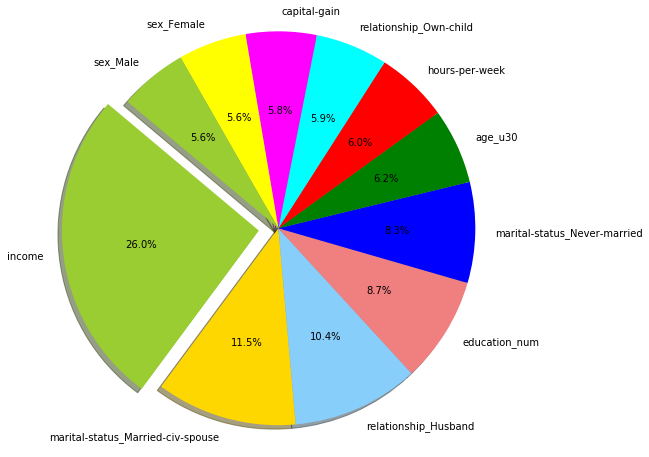

In [50]:
### correlation with labels Y

corr_Y = corr["income"].sort_values(axis = 0, ascending= False)[:11]
print(corr_Y)
plot_correlation(corr_Y)

sex_Female                           1.000000
sex_Male                             1.000000
gender                               1.000000
relationship_Husband                 0.580135
marital-status_Married-civ-spouse    0.431805
relationship_Unmarried               0.321273
relationship_Wife                    0.319311
occupation_Adm-clerical              0.263148
hours-per-week                       0.229309
marital-status_Divorced              0.228621
occupation_Craft-repair              0.223128
Name: gender, dtype: float64


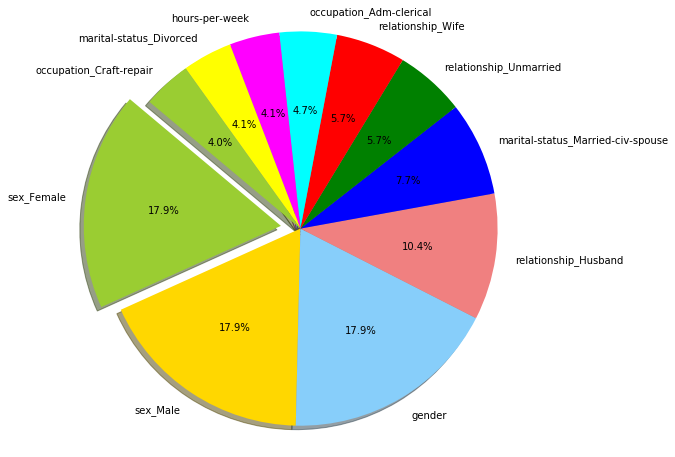

In [16]:
### correlation with attribute A

corr_A = corr["gender"].nlargest(11)
print(corr_A)
plot_correlation(corr_A)

### The 10 features most correlated with Y are: 
### 'marital-status_Married-civ-spouse', 'relationship_Husband', 'education_num', 'marital-status_Never-married', 'age_u30', 'hours-per-week', 'relationship_Own-child', 'capital-gain', 'sex_Female', 'sex_Male'

### The 10 features most correlated with A are: 
### 'sex_Female', 'sex_Male', 'relationship_Husband', 'marital-status_Married-civ-spouse', 'relationship_Unmarried', 'relationship_Wife', 'occupation_Adm-clerical', 'hours-per-week', 'marital-status_Divorced', 'occupation_Craft-repair'

#### 2- Train the classifier and evaluate on test set with the metrics accuracy ($acc$) and demographic parity  ($\Delta_{DP}$)

In [17]:
train_data_t  = PandasDF(train_data_X, train_data_Y, train_data_A)
train_loader = DataLoader(train_data_t, batch_size = 64, shuffle = True, drop_last = True) 

In [18]:
in_features = train_loader.dataset.tensors[0].shape[-1]
model = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
num_epoch = 100

train_model(model, criterion, optimizer, train_loader, num_epoch)

  1%|          | 1/100 [00:12<21:18, 12.91s/it]

Epoch:  0 Loss:  [0.4362639249723899]


 51%|█████     | 51/100 [13:39<12:56, 15.84s/it]

Epoch:  50 Loss:  [0.2654654415968628]


100%|██████████| 100/100 [26:35<00:00, 15.99s/it]

Training Loss:  0.21750456003763327
Done Training


In [19]:
test_data_t  = PandasDF(test_data_X, test_data_Y, test_data_A)
test_loader = DataLoader(test_data_t, batch_size = 64, shuffle = True, drop_last = False) 

In [20]:
test_model(model, test_loader)

Test accuracy is:  0.8401203857256925
Mean difference:  -0.1797535876950798
Demographic parity is:  0.1797535876950798


#### 3- Train and evaluate without attributes of high correlation with gender

In [21]:
s_att = list(corr_A.index)
s_att.remove('gender')
print(s_att)

['sex_Female', 'sex_Male', 'relationship_Husband', 'marital-status_Married-civ-spouse', 'relationship_Unmarried', 'relationship_Wife', 'occupation_Adm-clerical', 'hours-per-week', 'marital-status_Divorced', 'occupation_Craft-repair']


In [22]:
train_ws = train_data_X.drop(labels= s_att, axis=1)
test_ws = test_data_X.drop(labels= s_att, axis=1)

In [23]:
train_data_wst  = PandasDF(train_ws, train_data_Y, train_data_A)
train_loader_ws = DataLoader(train_data_wst, batch_size = 64, shuffle = True, drop_last = True) 

In [26]:
in_features = train_loader_ws.dataset.tensors[0].shape[-1]
model_ws = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_ws.parameters())
num_epoch = 100

train_model(model_ws, criterion, optimizer, train_loader_ws, num_epoch)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:10<17:48, 10.80s/it]

Epoch:  0 Loss:  [0.46893920873834855]




  2%|▏         | 2/100 [00:23<18:45, 11.49s/it]

  3%|▎         | 3/100 [00:38<20:02, 12.40s/it]

  4%|▍         | 4/100 [00:53<21:00, 13.13s/it]

  5%|▌         | 5/100 [01:08<21:37, 13.66s/it]

  6%|▌         | 6/100 [01:23<22:05, 14.10s/it]

  7%|▋         | 7/100 [01:38<22:14, 14.35s/it]

  8%|▊         | 8/100 [01:53<22:14, 14.51s/it]

  9%|▉         | 9/100 [02:08<22:23, 14.76s/it]

 10%|█         | 10/100 [02:23<22:22, 14.92s/it]

 11%|█         | 11/100 [02:38<22:12, 14.97s/it]

 12%|█▏        | 12/100 [02:54<22:05, 15.06s/it]

 13%|█▎        | 13/100 [03:09<21:52, 15.09s/it]

 14%|█▍        | 14/100 [03:24<21:50, 15.24s/it]

 15%|█▌        | 15/100 [03:40<21:47, 15.38s/it]

 16%|█▌        | 16/100 [03:56<21:37, 15.44s/it]

 17%|█▋        | 17/100 [04:11<21:18, 15.40s/it]

 18%|█▊        | 18/100 [04:26<21:06, 15.44s/it]

 19%|█▉        | 19/100 [04:42<20:52, 15.47s/it]

 20%|██        | 20/100 [04:58<20:39, 15.50s/it]

 21%|██        | 21/100 [05:14<20:42, 15.72s/it]

 22%|█

Epoch:  50 Loss:  [0.2683990374598776]




 52%|█████▏    | 52/100 [12:18<04:46,  5.97s/it]

 53%|█████▎    | 53/100 [12:20<03:40,  4.69s/it]

 54%|█████▍    | 54/100 [12:22<02:56,  3.83s/it]

 55%|█████▌    | 55/100 [12:24<02:25,  3.24s/it]

 56%|█████▌    | 56/100 [12:26<02:03,  2.81s/it]

 57%|█████▋    | 57/100 [12:27<01:46,  2.49s/it]

 58%|█████▊    | 58/100 [12:29<01:36,  2.30s/it]

 59%|█████▉    | 59/100 [12:31<01:27,  2.13s/it]

 60%|██████    | 60/100 [12:33<01:19,  2.00s/it]

 61%|██████    | 61/100 [12:34<01:14,  1.91s/it]

 62%|██████▏   | 62/100 [12:36<01:09,  1.84s/it]

 63%|██████▎   | 63/100 [12:38<01:06,  1.80s/it]

 64%|██████▍   | 64/100 [12:39<01:03,  1.77s/it]

 65%|██████▌   | 65/100 [12:41<01:01,  1.75s/it]

 66%|██████▌   | 66/100 [12:43<00:59,  1.75s/it]

 67%|██████▋   | 67/100 [12:45<00:57,  1.74s/it]

 68%|██████▊   | 68/100 [12:46<00:55,  1.75s/it]

 69%|██████▉   | 69/100 [12:48<00:54,  1.75s/it]

 70%|███████   | 70/100 [12:50<00:52,  1.75s/it]

 71%|███████   | 71/100 [12:52<00:50,  1.75s/it]

Training Loss:  0.25135177142687226
Done Training


In [27]:
test_data_wst  = PandasDF(test_ws, test_data_Y, test_data_A)
test_loader_ws = DataLoader(test_data_wst, batch_size = 64, shuffle = True, drop_last = False) 

In [28]:
test_model(model_ws, test_loader_ws)

Test accuracy is:  0.8318899330507954
Mean difference:  -0.12892608140431983
Demographic parity is:  0.12892608140431983


## Question 3

Here we take a look at how the features in the data correlate with the learned predictor $\hat{Y}$ for both groups $A=0$ and $A=1$

In [29]:
train_loader = DataLoader(train_data_t, batch_size = 100, shuffle = False, drop_last = False) 

In [30]:
predicted = torch.zeros(len(train_loader.dataset))
for i, (data, label, sensitive) in enumerate(train_loader):
        output = model(data)
        predicted[100*i:100*(i+1)] = (output.squeeze() > 0.).long()


In [31]:
predicted_df = pd.DataFrame(np.array(predicted), columns= [header[-1]])
data_p = pd.concat((train_data_X, predicted_df, train_data_A), axis = 1)

#### Which three features in the data are most correlated with the predicted $\hat{Y}$?

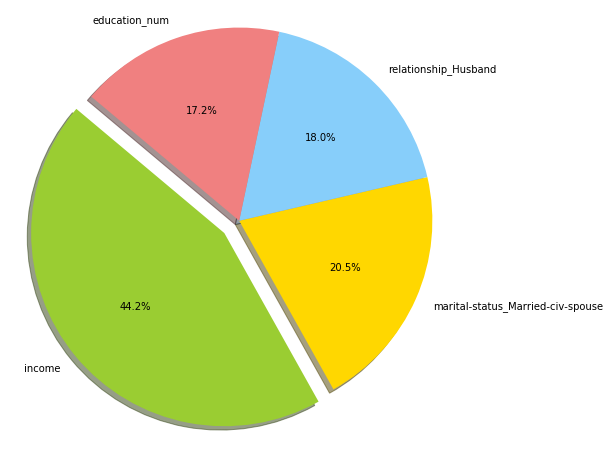

In [68]:
coor_y_hate= np.abs(data_p.corr()["income"]).nlargest(4)
coor_y_hate
plot_correlation(coor_y_hate)

#### Which three features in the data are most correlated with the predicted $\hat{Y}$, when we only look at examples where $A =0$?

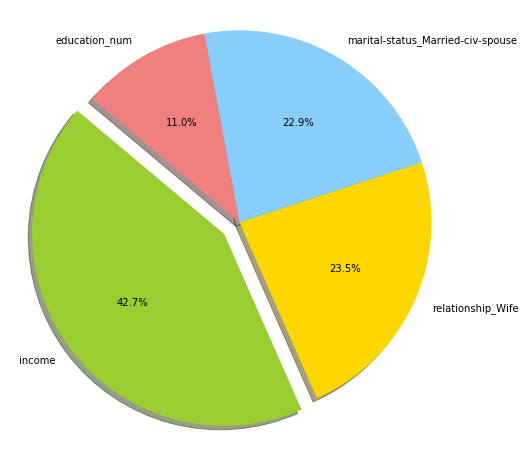

In [69]:
data_pA0 = data_p[data_p.gender != 1]
coor_y_hate_A0=np.abs(data_pA0.corr()["income"]).nlargest(4)
plot_correlation(coor_y_hate_A0)


#### Which three features in the data are most correlated with the predicted $\hat{Y}$, when we only look at examples where $A =1$?

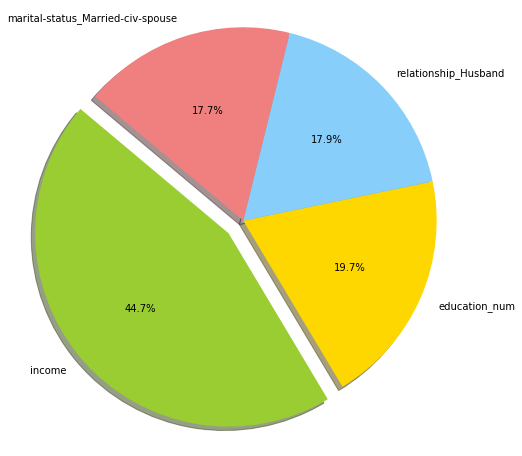

In [70]:
data_pA1 = data_p[data_p.gender != 0]
coor_y_hate_A1=np.abs(data_pA1.corr()["income"]).nlargest(4)
plot_correlation(coor_y_hate_A1)

## Question 4

Using the binary classifier built, we train for predicting  gender, $A$ instead of $Y$ and evaluate on test set using accuracy ($acc$) and reweighted accuracy ($\mathcal{R}$)

In [71]:
train_data_X_ = train_data_X.drop(labels= ["sex_Female", "sex_Male"], axis=1)

In [72]:
train_data_  = PandasDF(train_data_X_, train_data_Y, train_data_A)
train_loader_ = DataLoader(train_data_, batch_size = 64, shuffle = True, drop_last = True) 

In [73]:
test_data_X_ = test_data_X.drop(labels= ["sex_Female", "sex_Male"], axis=1)

In [74]:
test_data_  = PandasDF(test_data_X_, test_data_Y, test_data_A)
test_loader_ = DataLoader(test_data_, batch_size = 64, shuffle = True, drop_last = False) 

In [75]:
in_features = train_loader_.dataset.tensors[0].shape[-1]
model_ = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_.parameters())
num_epoch = 200

train_model_(model_, criterion, optimizer, train_loader_, num_epoch)



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:01<04:04,  1.23s/it]

Epoch:  0 Loss:  [0.473266777149169]




  1%|          | 2/200 [00:02<04:14,  1.29s/it]

  2%|▏         | 3/200 [00:04<04:31,  1.38s/it]

  2%|▏         | 4/200 [00:05<04:44,  1.45s/it]

  2%|▎         | 5/200 [00:07<04:54,  1.51s/it]

  3%|▎         | 6/200 [00:09<05:02,  1.56s/it]

  4%|▎         | 7/200 [00:10<05:11,  1.61s/it]

  4%|▍         | 8/200 [00:12<05:15,  1.64s/it]

  4%|▍         | 9/200 [00:14<05:17,  1.66s/it]

  5%|▌         | 10/200 [00:16<05:25,  1.72s/it]

  6%|▌         | 11/200 [00:18<05:31,  1.75s/it]

  6%|▌         | 12/200 [00:19<05:31,  1.77s/it]

  6%|▋         | 13/200 [00:21<05:30,  1.77s/it]

  7%|▋         | 14/200 [00:23<05:30,  1.78s/it]

  8%|▊         | 15/200 [00:25<05:30,  1.79s/it]

  8%|▊         | 16/200 [00:26<05:28,  1.78s/it]

  8%|▊         | 17/200 [00:28<05:27,  1.79s/it]

  9%|▉         | 18/200 [00:30<05:22,  1.77s/it]

 10%|▉         | 19/200 [00:32<05:19,  1.76s/it]

 10%|█         | 20/200 [00:33<05:15,  1.75s/it]

 10%|█         | 21/200 [00:35<05:15,  1.76s/it]

 11%|█

Epoch:  50 Loss:  [0.2639880620863224]




 26%|██▌       | 52/200 [01:32<04:40,  1.90s/it]

 26%|██▋       | 53/200 [01:34<04:43,  1.93s/it]

 27%|██▋       | 54/200 [01:36<04:39,  1.91s/it]

 28%|██▊       | 55/200 [01:38<04:39,  1.93s/it]

 28%|██▊       | 56/200 [01:40<04:38,  1.93s/it]

 28%|██▊       | 57/200 [01:42<04:38,  1.95s/it]

 29%|██▉       | 58/200 [01:44<04:36,  1.95s/it]

 30%|██▉       | 59/200 [01:46<04:32,  1.93s/it]

 30%|███       | 60/200 [01:48<04:35,  1.97s/it]

 30%|███       | 61/200 [01:50<04:39,  2.01s/it]

 31%|███       | 62/200 [01:52<04:35,  2.00s/it]

 32%|███▏      | 63/200 [01:54<04:32,  1.99s/it]

 32%|███▏      | 64/200 [01:56<04:32,  2.00s/it]

 32%|███▎      | 65/200 [01:58<04:31,  2.01s/it]

 33%|███▎      | 66/200 [02:00<04:27,  2.00s/it]

 34%|███▎      | 67/200 [02:02<04:20,  1.96s/it]

 34%|███▍      | 68/200 [02:04<04:16,  1.94s/it]

 34%|███▍      | 69/200 [02:06<04:11,  1.92s/it]

 35%|███▌      | 70/200 [02:07<04:08,  1.91s/it]

 36%|███▌      | 71/200 [02:09<04:10,  1.94s/it]

Epoch:  100 Loss:  [0.20702944021253386]




 51%|█████     | 102/200 [03:09<03:09,  1.93s/it]

 52%|█████▏    | 103/200 [03:11<03:06,  1.92s/it]

 52%|█████▏    | 104/200 [03:13<03:08,  1.96s/it]

 52%|█████▎    | 105/200 [03:15<03:09,  2.00s/it]

 53%|█████▎    | 106/200 [03:17<03:06,  1.99s/it]

 54%|█████▎    | 107/200 [03:19<03:03,  1.98s/it]

 54%|█████▍    | 108/200 [03:21<03:02,  1.98s/it]

 55%|█████▍    | 109/200 [03:23<02:59,  1.98s/it]

 55%|█████▌    | 110/200 [03:25<02:56,  1.96s/it]

 56%|█████▌    | 111/200 [03:27<02:56,  1.98s/it]

 56%|█████▌    | 112/200 [03:29<02:52,  1.96s/it]

 56%|█████▋    | 113/200 [03:31<02:49,  1.95s/it]

 57%|█████▋    | 114/200 [03:32<02:46,  1.94s/it]

 57%|█████▊    | 115/200 [03:34<02:43,  1.92s/it]

 58%|█████▊    | 116/200 [03:36<02:42,  1.93s/it]

 58%|█████▊    | 117/200 [03:38<02:41,  1.95s/it]

 59%|█████▉    | 118/200 [03:40<02:40,  1.96s/it]

 60%|█████▉    | 119/200 [03:42<02:39,  1.97s/it]

 60%|██████    | 120/200 [03:44<02:38,  1.98s/it]

 60%|██████    | 121/200 [03:

Epoch:  150 Loss:  [0.19249541227678618]




 76%|███████▌  | 152/200 [04:50<01:41,  2.12s/it]

 76%|███████▋  | 153/200 [04:53<01:39,  2.11s/it]

 77%|███████▋  | 154/200 [04:55<01:37,  2.13s/it]

 78%|███████▊  | 155/200 [04:57<01:38,  2.18s/it]

 78%|███████▊  | 156/200 [04:59<01:35,  2.16s/it]

 78%|███████▊  | 157/200 [05:01<01:32,  2.14s/it]

 79%|███████▉  | 158/200 [05:03<01:28,  2.11s/it]

 80%|███████▉  | 159/200 [05:05<01:26,  2.10s/it]

 80%|████████  | 160/200 [05:07<01:23,  2.10s/it]

 80%|████████  | 161/200 [05:10<01:21,  2.10s/it]

 81%|████████  | 162/200 [05:12<01:19,  2.09s/it]

 82%|████████▏ | 163/200 [05:14<01:17,  2.09s/it]

 82%|████████▏ | 164/200 [05:16<01:15,  2.09s/it]

 82%|████████▎ | 165/200 [05:18<01:13,  2.10s/it]

 83%|████████▎ | 166/200 [05:20<01:11,  2.10s/it]

 84%|████████▎ | 167/200 [05:22<01:08,  2.08s/it]

 84%|████████▍ | 168/200 [05:24<01:06,  2.09s/it]

 84%|████████▍ | 169/200 [05:26<01:05,  2.10s/it]

 85%|████████▌ | 170/200 [05:28<01:03,  2.11s/it]

 86%|████████▌ | 171/200 [05:

Training Loss:  0.1956017905915056
Done Training


In [76]:
test_model_(model_, test_loader_)

Test accuracy is:  0.8108838523432221
Reweighted accuracy is:  0.7772180470668089


#### **Retraining and evaluating without attributes of high correlation with gender**

In [77]:
train_data_ws_  = PandasDF(train_ws, train_data_Y, train_data_A)
train_loader_ws = DataLoader(train_data_ws_, batch_size = 64, shuffle = True, drop_last = True) 
test_data_ws_  = PandasDF(test_ws, test_data_Y, test_data_A)
test_loader_ws_ = DataLoader(test_data_ws_, batch_size = 64, shuffle = True, drop_last = False) 

In [78]:
in_features = train_loader_ws.dataset.tensors[0].shape[-1]
model_ws_ = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_ws_.parameters())
num_epoch = 200

train_model_(model_ws_, criterion, optimizer, train_loader_ws, num_epoch)



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:01<04:06,  1.24s/it]

Epoch:  0 Loss:  [0.5937219917735751]




  1%|          | 2/200 [00:02<04:15,  1.29s/it]

  2%|▏         | 3/200 [00:04<04:31,  1.38s/it]

  2%|▏         | 4/200 [00:05<04:45,  1.45s/it]

  2%|▎         | 5/200 [00:07<04:52,  1.50s/it]

  3%|▎         | 6/200 [00:09<05:02,  1.56s/it]

  4%|▎         | 7/200 [00:10<05:11,  1.61s/it]

  4%|▍         | 8/200 [00:12<05:10,  1.62s/it]

  4%|▍         | 9/200 [00:14<05:11,  1.63s/it]

  5%|▌         | 10/200 [00:15<05:17,  1.67s/it]

  6%|▌         | 11/200 [00:17<05:18,  1.68s/it]

  6%|▌         | 12/200 [00:19<05:20,  1.70s/it]

  6%|▋         | 13/200 [00:21<05:19,  1.71s/it]

  7%|▋         | 14/200 [00:22<05:19,  1.72s/it]

  8%|▊         | 15/200 [00:24<05:23,  1.75s/it]

  8%|▊         | 16/200 [00:26<05:26,  1.77s/it]

  8%|▊         | 17/200 [00:28<05:25,  1.78s/it]

  9%|▉         | 18/200 [00:30<05:27,  1.80s/it]

 10%|▉         | 19/200 [00:32<05:31,  1.83s/it]

 10%|█         | 20/200 [00:34<05:38,  1.88s/it]

 10%|█         | 21/200 [00:36<05:45,  1.93s/it]

 11%|█

Epoch:  50 Loss:  [0.40415594553699213]




 26%|██▌       | 52/200 [01:37<05:04,  2.06s/it]

 26%|██▋       | 53/200 [01:40<05:04,  2.07s/it]

 27%|██▋       | 54/200 [01:42<04:59,  2.05s/it]

 28%|██▊       | 55/200 [01:44<05:01,  2.08s/it]

 28%|██▊       | 56/200 [01:46<04:57,  2.07s/it]

 28%|██▊       | 57/200 [01:48<04:53,  2.05s/it]

 29%|██▉       | 58/200 [01:50<05:12,  2.20s/it]

 30%|██▉       | 59/200 [01:53<05:33,  2.37s/it]

 30%|███       | 60/200 [01:55<05:20,  2.29s/it]

 30%|███       | 61/200 [01:57<05:11,  2.24s/it]

 31%|███       | 62/200 [01:59<05:00,  2.18s/it]

 32%|███▏      | 63/200 [02:02<04:56,  2.16s/it]

 32%|███▏      | 64/200 [02:04<04:47,  2.12s/it]

 32%|███▎      | 65/200 [02:05<04:39,  2.07s/it]

 33%|███▎      | 66/200 [02:07<04:35,  2.05s/it]

 34%|███▎      | 67/200 [02:09<04:28,  2.02s/it]

 34%|███▍      | 68/200 [02:11<04:24,  2.00s/it]

 34%|███▍      | 69/200 [02:13<04:20,  1.99s/it]

 35%|███▌      | 70/200 [02:15<04:18,  1.99s/it]

 36%|███▌      | 71/200 [02:17<04:16,  1.99s/it]

Epoch:  100 Loss:  [0.3758932248493335]




 51%|█████     | 102/200 [03:20<03:22,  2.07s/it]

 52%|█████▏    | 103/200 [03:22<03:21,  2.08s/it]

 52%|█████▏    | 104/200 [03:24<03:19,  2.08s/it]

 52%|█████▎    | 105/200 [03:26<03:17,  2.08s/it]

 53%|█████▎    | 106/200 [03:29<03:14,  2.07s/it]

 54%|█████▎    | 107/200 [03:31<03:13,  2.08s/it]

 54%|█████▍    | 108/200 [03:33<03:11,  2.08s/it]

 55%|█████▍    | 109/200 [03:35<03:09,  2.08s/it]

 55%|█████▌    | 110/200 [03:37<03:06,  2.08s/it]

 56%|█████▌    | 111/200 [03:39<03:05,  2.08s/it]

 56%|█████▌    | 112/200 [03:41<03:03,  2.09s/it]

 56%|█████▋    | 113/200 [03:43<03:01,  2.08s/it]

 57%|█████▋    | 114/200 [03:45<02:59,  2.09s/it]

 57%|█████▊    | 115/200 [03:47<02:57,  2.09s/it]

 58%|█████▊    | 116/200 [03:49<02:56,  2.10s/it]

 58%|█████▊    | 117/200 [03:52<02:55,  2.11s/it]

 59%|█████▉    | 118/200 [03:54<02:53,  2.12s/it]

 60%|█████▉    | 119/200 [03:56<02:51,  2.11s/it]

 60%|██████    | 120/200 [03:58<02:48,  2.11s/it]

 60%|██████    | 121/200 [04:

Epoch:  150 Loss:  [0.37139838423037314]




 76%|███████▌  | 152/200 [05:11<01:52,  2.34s/it]

 76%|███████▋  | 153/200 [05:13<01:49,  2.32s/it]

 77%|███████▋  | 154/200 [05:15<01:46,  2.31s/it]

 78%|███████▊  | 155/200 [05:17<01:44,  2.32s/it]

 78%|███████▊  | 156/200 [05:20<01:42,  2.32s/it]

 78%|███████▊  | 157/200 [05:22<01:39,  2.31s/it]

 79%|███████▉  | 158/200 [05:24<01:36,  2.30s/it]

 80%|███████▉  | 159/200 [05:27<01:34,  2.30s/it]

 80%|████████  | 160/200 [05:29<01:32,  2.31s/it]

 80%|████████  | 161/200 [05:31<01:32,  2.36s/it]

 81%|████████  | 162/200 [05:34<01:29,  2.35s/it]

 82%|████████▏ | 163/200 [05:36<01:27,  2.35s/it]

 82%|████████▏ | 164/200 [05:39<01:24,  2.36s/it]

 82%|████████▎ | 165/200 [05:41<01:22,  2.37s/it]

 83%|████████▎ | 166/200 [05:43<01:20,  2.36s/it]

 84%|████████▎ | 167/200 [05:46<01:18,  2.37s/it]

 84%|████████▍ | 168/200 [05:48<01:15,  2.37s/it]

 84%|████████▍ | 169/200 [05:50<01:13,  2.37s/it]

 85%|████████▌ | 170/200 [05:53<01:12,  2.41s/it]

 86%|████████▌ | 171/200 [05:

Training Loss:  0.37392551183356376
Done Training


In [79]:
test_model_(model_ws_, test_loader_ws_)

Test accuracy is:  0.7203488729193539
Reweighted accuracy is:  0.6560009620862596
